In [1]:
!pip install git+https://github.com/brianbt/btorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/brianbt/btorch to /tmp/pip-req-build-18i2mo69
  Running command git clone -q https://github.com/brianbt/btorch /tmp/pip-req-build-18i2mo69


In [2]:
import torch
import btorch
from btorch import nn
import btorch.nn.functional as F
from btorch.vision.utils import UnNormalize
from torchvision import transforms, datasets
from tqdm import tqdm
from matplotlib import pyplot as plt

# Load Dataset, CIFAR10

In [3]:
# Load MNIST dataset, do augmentation on the trainset
transform_train = transforms.Compose([
  transforms.ToTensor()
  ])
transform_test = transforms.Compose([
  transforms.ToTensor()
  ])
trainset = datasets.MNIST('./mnist',train=True, download=True, transform=transform_train)
testset = datasets.MNIST('./mnist',train=False, download=True, transform=transform_test)

# # Only select the `4` class
# train_idx = trainset.targets == 4
# test_idx = testset.targets == 4
# trainset.targets = trainset.targets[train_idx]
# trainset.data = trainset.data[train_idx]
# testset.targets = testset.targets[test_idx]
# testset.data = testset.data[test_idx]

# Create GAN Model

## Generator and Discriminator

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.input = nn.Linear(latent_dim, 64*4*4)
        self.c1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.c2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.c3 = nn.ConvTranspose2d(16, 1, 4, stride=2)
    def forward(self,x):
        x=torch.relu(self.input(x))
        x=x.view(-1,64,4,4)
        x=torch.relu(self.bn1(self.c1(x)))#(32,7,7)
        x=torch.relu(self.bn2(self.c2(x)))#(16,13,13)
        x=torch.tanh(self.c3(x))#(1,28,28)
        return x
    def sample(self, batch_size = 1):
        noise = torch.randn((batch_size, self.latent_dim), device=self.device())
        return self.forward(noise)
  
  

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.c1 = nn.Conv2d(1, 16, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.c2 = nn.Conv2d(16, 32, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.c3 = nn.Conv2d(32, 64, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.l = nn.Linear(1024, 1)
    def forward(self,x):
        x=F.leaky_relu(self.bn1(self.c1(x)), 0.2)#(16, 16, 16)
        x=F.leaky_relu(self.bn2(self.c2(x)), 0.2)#(32, 8, 8)
        x=F.leaky_relu(self.bn3(self.c3(x)), 0.2)#(64,4,4)
        x=torch.flatten(x, 1)
        return torch.sigmoid(self.l(x))
        

## Lets test the Generator and Discriminator output

In [6]:
g = Generator(100)
# print(g.summary(input_size=(16,100)))
d = Discriminator()
# print(d.summary(input_size=(16,1,28,28)))
print(d(g.sample(1)).shape)

torch.Size([1, 1])


## Create GAN Module

In [7]:
class GAN(nn.Module):
    def __init__(self, latent_dim):
        super(GAN, self).__init__()
        self.latent_dim = latent_dim
        self.g=Generator(latent_dim)
        self.d=Discriminator()
    def forward(self,x):
        return self.d(x)
    def sample(self, batch_size):
        return self.g.sample(batch_size)
    
    @classmethod
    def train_epoch(cls, net, criterion, trainloader, optimizer, epoch_idx, device='cuda', config=None):
        """This is the very basic training function for one epoch. Override this function when necessary
            
        Returns:
            (float): train_loss
        """
        net.g.train()
        net.d.train()
        G_loss = 0
        D_loss = 0
        G_curr_loss = 0 
        D_curr_loss = torch.nan
        pbar = tqdm(enumerate(trainloader), total=len(trainloader))
        for batch_idx, (inputs, _) in pbar:
            # Trian G ###############################
            optimizer['G'].zero_grad()
            fake_inputs = net.sample(inputs.shape[0])
            fool_labels = torch.ones(inputs.shape[0], device=net.device())
            fool_predicted = net.d(fake_inputs).view(-1)
            G_fool_loss = criterion(fool_predicted, fool_labels)
            G_fool_loss.backward()
            
            optimizer['G'].step()
            G_curr_loss = G_fool_loss.item()
            G_loss += G_curr_loss
            
            # Trian D ###############################
            if epoch_idx >= 0: # train Discriminator less
                optimizer['D'].zero_grad()
                ## Train with real data
                inputs = inputs.to(device)
                real_labels = torch.ones(inputs.shape[0], device=net.device())
                real_predicted = net.d(inputs).view(-1)
                D_real_loss = criterion(real_predicted, real_labels)

                ## Train with fake data
                fake_labels = torch.zeros(inputs.shape[0], device=net.device())
                fake_predicted = net.d(fake_inputs.detach()).view(-1)
                D_fake_loss = criterion(fake_predicted, fake_labels)

                D_curr_lossB = D_real_loss+D_fake_loss
                D_curr_lossB.backward()
                optimizer['D'].step()
                
                D_curr_loss = D_curr_lossB.item()
                D_loss = D_loss + D_curr_loss
            
            pbar.set_description(
                f"epoch {epoch_idx+1} iter {batch_idx}: D loss {D_curr_loss:.5f}, G loss {G_curr_loss:.5f}.")
        return {'D_loss': D_loss/(batch_idx+1), 'G_loss': G_loss/(batch_idx+1)}

    @classmethod
    def before_each_train_epoch(cls, net, criterion, optimizer, trainloader, testloader=None, epoch_idx=0, lr_scheduler=None, config=None):
      config['evol'].append(net.g(config['evol_seed']))
      # pass

    @classmethod
    def test_epoch(cls, net, criterion, testloader, epoch_idx=0, scoring=None, device='cuda', config=None):
        """This is the very basic evaluating function for one epoch. Override this function when necessary
            
        Returns:
            (float): eval_loss
        """
        net.g.eval()
        net.d.eval()
        G_loss = 0
        D_loss = 0
        with torch.inference_mode():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                # Test G ###############################
                fake_inputs = net.sample(inputs.shape[0])
                fool_labels = torch.ones(inputs.shape[0], device=net.device())
                fool_predicted = net.d(fake_inputs).view(-1)
                G_fool_loss = criterion(fool_predicted, fool_labels)
                G_loss += G_fool_loss.item()
                
                
                # Test D ###############################
                if epoch_idx >= 0:
                    ## Test with real data
                    inputs = inputs.to(device)
                    real_labels = torch.ones(inputs.shape[0], device=net.device())
                    real_predicted = net.d(inputs).view(-1)
                    D_real_loss = criterion(real_predicted, real_labels)

                    ## Test with fake data
                    fake_labels = torch.zeros(inputs.shape[0], device=net.device())
                    fake_predicted = net.d(fake_inputs).view(-1)
                    D_fake_loss = criterion(fake_predicted, fake_labels)

                    D_loss = D_loss + (D_real_loss.item() + D_fake_loss.item())/2

                
                
        return {'D_loss': D_loss/(batch_idx+1), 'G_loss': G_loss/(batch_idx+1)}

## Paper init weight as (0, 0.02)

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Init Model

In [9]:
# Model
latent_dim = 100
gan = GAN(latent_dim)
gan.g.apply(weights_init)
gan.d.apply(weights_init)

# Loss & Optimizer & Config
gan._lossfn = nn.BCELoss()
gan._optimizer = {'D':torch.optim.Adam(gan.d.parameters(), lr=0.0002, betas=(0.5, 0.999)),
                  'G':torch.optim.Adam(gan.g.parameters(), lr=0.0002, betas=(0.5, 0.999))}
gan._config['max_epoch'] = 100
gan._config['val_freq'] = 10
gan._config['evol'] = []
gan._config['evol_seed'] = torch.randn((1,100), device='cuda')

# Set GPU
gan.auto_gpu()

auto_gpu: using GPU (Tesla T4)


## Training

In [10]:
gan.fit(trainset, validation_data=testset, batch_size=256, drop_last=True)

epoch 1 iter 233: D loss 0.39182, G loss 1.54528.: 100%|██████████| 234/234 [00:11<00:00, 19.63it/s]


Epoch 0: Training loss: {'D_loss': 0.3602856361331084, 'G_loss': 2.1615521943467293}. Testing loss: {'D_loss': 0.5561595349282026, 'G_loss': 3.837107599258423}


epoch 2 iter 233: D loss 0.09544, G loss 3.59567.: 100%|██████████| 234/234 [00:08<00:00, 26.50it/s]

Epoch 1: Training loss: {'D_loss': 0.2280653286088481, 'G_loss': 3.007394012477663}. Testing loss: Not Provided



epoch 3 iter 233: D loss 0.06488, G loss 3.74803.: 100%|██████████| 234/234 [00:08<00:00, 26.26it/s]

Epoch 2: Training loss: {'D_loss': 0.17475386232965523, 'G_loss': 3.59090192297585}. Testing loss: Not Provided



epoch 4 iter 233: D loss 0.10221, G loss 3.16460.: 100%|██████████| 234/234 [00:09<00:00, 25.89it/s]

Epoch 3: Training loss: {'D_loss': 0.29693639209955675, 'G_loss': 3.308719390527142}. Testing loss: Not Provided



epoch 5 iter 233: D loss 0.17368, G loss 2.89748.: 100%|██████████| 234/234 [00:08<00:00, 26.21it/s]

Epoch 4: Training loss: {'D_loss': 0.35137312575920016, 'G_loss': 3.080385690678357}. Testing loss: Not Provided



epoch 6 iter 233: D loss 0.18118, G loss 4.00670.: 100%|██████████| 234/234 [00:08<00:00, 26.41it/s]

Epoch 5: Training loss: {'D_loss': 0.28157898783683777, 'G_loss': 2.9580289187092874}. Testing loss: Not Provided



epoch 7 iter 233: D loss 2.22844, G loss 0.16239.: 100%|██████████| 234/234 [00:09<00:00, 25.66it/s]

Epoch 6: Training loss: {'D_loss': 0.4049958704501136, 'G_loss': 2.7306599500071673}. Testing loss: Not Provided



epoch 8 iter 233: D loss 0.22458, G loss 3.24228.: 100%|██████████| 234/234 [00:09<00:00, 25.93it/s]


Epoch 7: Training loss: {'D_loss': 0.3866943639949856, 'G_loss': 2.600951801635261}. Testing loss: Not Provided


epoch 9 iter 233: D loss 0.32899, G loss 3.06299.: 100%|██████████| 234/234 [00:09<00:00, 25.98it/s]

Epoch 8: Training loss: {'D_loss': 0.4436724852038245, 'G_loss': 2.3994793388674145}. Testing loss: Not Provided



epoch 10 iter 233: D loss 0.35621, G loss 2.04352.: 100%|██████████| 234/234 [00:09<00:00, 23.80it/s]

Epoch 9: Training loss: {'D_loss': 0.4255311139501058, 'G_loss': 2.3557172823920207}. Testing loss: Not Provided



epoch 11 iter 233: D loss 0.38842, G loss 2.54531.: 100%|██████████| 234/234 [00:09<00:00, 25.79it/s]


Epoch 10: Training loss: {'D_loss': 0.45681558441147846, 'G_loss': 2.2370500017562485}. Testing loss: {'D_loss': 0.5654801990807057, 'G_loss': 0.8899557072877884}


epoch 12 iter 233: D loss 0.38740, G loss 1.83370.: 100%|██████████| 234/234 [00:08<00:00, 26.00it/s]


Epoch 11: Training loss: {'D_loss': 0.44118962965459907, 'G_loss': 2.194477713897697}. Testing loss: Not Provided


epoch 13 iter 233: D loss 0.44556, G loss 2.43733.: 100%|██████████| 234/234 [00:09<00:00, 25.85it/s]


Epoch 12: Training loss: {'D_loss': 0.46361963094299674, 'G_loss': 2.154935179103134}. Testing loss: Not Provided


epoch 14 iter 233: D loss 0.45331, G loss 1.69255.: 100%|██████████| 234/234 [00:09<00:00, 25.70it/s]


Epoch 13: Training loss: {'D_loss': 0.5147477797208688, 'G_loss': 1.9988468238431165}. Testing loss: Not Provided


epoch 15 iter 233: D loss 0.59467, G loss 1.17352.: 100%|██████████| 234/234 [00:09<00:00, 25.76it/s]

Epoch 14: Training loss: {'D_loss': 0.5088887479570177, 'G_loss': 1.958134929339091}. Testing loss: Not Provided



epoch 16 iter 233: D loss 0.44483, G loss 1.56866.: 100%|██████████| 234/234 [00:09<00:00, 25.25it/s]

Epoch 15: Training loss: {'D_loss': 0.5046910741645046, 'G_loss': 2.0189139124674673}. Testing loss: Not Provided



epoch 17 iter 233: D loss 0.71669, G loss 0.92159.: 100%|██████████| 234/234 [00:09<00:00, 25.53it/s]

Epoch 16: Training loss: {'D_loss': 0.598506630740614, 'G_loss': 1.7962729766582832}. Testing loss: Not Provided



epoch 18 iter 233: D loss 0.38923, G loss 1.95236.: 100%|██████████| 234/234 [00:09<00:00, 25.42it/s]


Epoch 17: Training loss: {'D_loss': 0.5309874161950543, 'G_loss': 1.9112018730141158}. Testing loss: Not Provided


epoch 19 iter 233: D loss 0.50970, G loss 1.40184.: 100%|██████████| 234/234 [00:09<00:00, 25.57it/s]

Epoch 18: Training loss: {'D_loss': 0.5404786150424908, 'G_loss': 1.9508275835432558}. Testing loss: Not Provided



epoch 20 iter 233: D loss 0.52109, G loss 2.23963.: 100%|██████████| 234/234 [00:09<00:00, 25.50it/s]

Epoch 19: Training loss: {'D_loss': 0.5792032247170423, 'G_loss': 1.8324158739330423}. Testing loss: Not Provided



epoch 21 iter 233: D loss 0.44196, G loss 1.72771.: 100%|██████████| 234/234 [00:09<00:00, 25.71it/s]


Epoch 20: Training loss: {'D_loss': 0.5433483149251367, 'G_loss': 1.9100257076768794}. Testing loss: {'D_loss': 0.2323908669397235, 'G_loss': 2.4843576009750366}


epoch 22 iter 233: D loss 0.72953, G loss 3.19682.: 100%|██████████| 234/234 [00:09<00:00, 25.60it/s]

Epoch 21: Training loss: {'D_loss': 0.5376724612254363, 'G_loss': 1.9496558193977063}. Testing loss: Not Provided



epoch 23 iter 233: D loss 0.65978, G loss 2.53738.: 100%|██████████| 234/234 [00:09<00:00, 25.31it/s]

Epoch 22: Training loss: {'D_loss': 0.5889656851943742, 'G_loss': 1.8039078317646287}. Testing loss: Not Provided



epoch 24 iter 233: D loss 0.63349, G loss 1.98170.: 100%|██████████| 234/234 [00:09<00:00, 25.61it/s]


Epoch 23: Training loss: {'D_loss': 0.6374445906561664, 'G_loss': 1.73850811795037}. Testing loss: Not Provided


epoch 25 iter 233: D loss 0.63996, G loss 2.09242.: 100%|██████████| 234/234 [00:09<00:00, 25.97it/s]

Epoch 24: Training loss: {'D_loss': 0.6091465383258641, 'G_loss': 1.7301183483030043}. Testing loss: Not Provided



epoch 26 iter 233: D loss 0.55300, G loss 1.35265.: 100%|██████████| 234/234 [00:09<00:00, 25.61it/s]

Epoch 25: Training loss: {'D_loss': 0.5620778106216692, 'G_loss': 1.8639047232448545}. Testing loss: Not Provided



epoch 27 iter 233: D loss 0.74771, G loss 2.83677.: 100%|██████████| 234/234 [00:09<00:00, 23.78it/s]


Epoch 26: Training loss: {'D_loss': 0.5486268671149881, 'G_loss': 1.9021097391079633}. Testing loss: Not Provided


epoch 28 iter 233: D loss 0.45925, G loss 1.67792.: 100%|██████████| 234/234 [00:09<00:00, 25.72it/s]

Epoch 27: Training loss: {'D_loss': 0.531658945302678, 'G_loss': 1.9437899115758064}. Testing loss: Not Provided



epoch 29 iter 233: D loss 0.55810, G loss 1.49900.: 100%|██████████| 234/234 [00:08<00:00, 26.00it/s]

Epoch 28: Training loss: {'D_loss': 0.5771869320390571, 'G_loss': 1.864251907564636}. Testing loss: Not Provided



epoch 30 iter 233: D loss 0.55427, G loss 2.68766.: 100%|██████████| 234/234 [00:09<00:00, 25.52it/s]

Epoch 29: Training loss: {'D_loss': 0.5454634569394283, 'G_loss': 1.9088133306075366}. Testing loss: Not Provided



epoch 31 iter 233: D loss 0.59591, G loss 1.35834.: 100%|██████████| 234/234 [00:09<00:00, 25.82it/s]


Epoch 30: Training loss: {'D_loss': 0.5556444921809384, 'G_loss': 1.9009948637750413}. Testing loss: {'D_loss': 0.8593846489399671, 'G_loss': 1.8271062606811523}


epoch 32 iter 233: D loss 0.44950, G loss 1.68112.: 100%|██████████| 234/234 [00:09<00:00, 25.60it/s]

Epoch 31: Training loss: {'D_loss': 0.5561393752821491, 'G_loss': 1.873281861981775}. Testing loss: Not Provided



epoch 33 iter 233: D loss 0.55642, G loss 1.60122.: 100%|██████████| 234/234 [00:09<00:00, 25.57it/s]


Epoch 32: Training loss: {'D_loss': 0.6191360483057479, 'G_loss': 1.821394209550996}. Testing loss: Not Provided


epoch 34 iter 233: D loss 0.57238, G loss 1.28905.: 100%|██████████| 234/234 [00:09<00:00, 25.74it/s]

Epoch 33: Training loss: {'D_loss': 0.5856253685604813, 'G_loss': 1.8184483698290637}. Testing loss: Not Provided



epoch 35 iter 233: D loss 0.60424, G loss 2.39504.: 100%|██████████| 234/234 [00:08<00:00, 26.11it/s]

Epoch 34: Training loss: {'D_loss': 0.5522041885007141, 'G_loss': 1.923270033974933}. Testing loss: Not Provided



epoch 36 iter 233: D loss 0.42966, G loss 2.07583.: 100%|██████████| 234/234 [00:09<00:00, 25.23it/s]


Epoch 35: Training loss: {'D_loss': 0.5269025131168529, 'G_loss': 1.9717198645966685}. Testing loss: Not Provided


epoch 37 iter 233: D loss 0.43126, G loss 1.98184.: 100%|██████████| 234/234 [00:09<00:00, 25.47it/s]

Epoch 36: Training loss: {'D_loss': 0.5379309442817656, 'G_loss': 1.9618776539961498}. Testing loss: Not Provided



epoch 38 iter 233: D loss 0.43797, G loss 2.36150.: 100%|██████████| 234/234 [00:09<00:00, 25.27it/s]

Epoch 37: Training loss: {'D_loss': 0.4967476258165816, 'G_loss': 2.052605032411396}. Testing loss: Not Provided



epoch 39 iter 233: D loss 0.41680, G loss 2.28952.: 100%|██████████| 234/234 [00:09<00:00, 25.70it/s]

Epoch 38: Training loss: {'D_loss': 0.5204638561122438, 'G_loss': 2.013873576353758}. Testing loss: Not Provided



epoch 40 iter 233: D loss 0.46416, G loss 1.50760.: 100%|██████████| 234/234 [00:09<00:00, 25.85it/s]

Epoch 39: Training loss: {'D_loss': 0.520179563607925, 'G_loss': 2.033464568420353}. Testing loss: Not Provided



epoch 41 iter 233: D loss 0.52533, G loss 2.22930.: 100%|██████████| 234/234 [00:09<00:00, 25.60it/s]


Epoch 40: Training loss: {'D_loss': 0.5155299432002581, 'G_loss': 2.0313587901938677}. Testing loss: {'D_loss': 0.9536203487992286, 'G_loss': 1.3134284884929657}


epoch 42 iter 233: D loss 0.50574, G loss 1.35751.: 100%|██████████| 234/234 [00:09<00:00, 25.51it/s]

Epoch 41: Training loss: {'D_loss': 0.5035493684630109, 'G_loss': 2.066348565949334}. Testing loss: Not Provided



epoch 43 iter 233: D loss 0.38374, G loss 2.35321.: 100%|██████████| 234/234 [00:09<00:00, 25.86it/s]

Epoch 42: Training loss: {'D_loss': 0.5235195193025801, 'G_loss': 2.020760760602788}. Testing loss: Not Provided



epoch 44 iter 233: D loss 0.52679, G loss 3.21677.: 100%|██████████| 234/234 [00:09<00:00, 25.31it/s]

Epoch 43: Training loss: {'D_loss': 0.5458405424132307, 'G_loss': 1.9699655333135881}. Testing loss: Not Provided



epoch 45 iter 233: D loss 0.52425, G loss 1.68430.: 100%|██████████| 234/234 [00:09<00:00, 25.70it/s]

Epoch 44: Training loss: {'D_loss': 0.5207502696758661, 'G_loss': 2.0218000890862227}. Testing loss: Not Provided



epoch 46 iter 233: D loss 0.32048, G loss 2.35179.: 100%|██████████| 234/234 [00:09<00:00, 25.20it/s]

Epoch 45: Training loss: {'D_loss': 0.5039886325343043, 'G_loss': 2.0566202705232506}. Testing loss: Not Provided



epoch 47 iter 233: D loss 0.47797, G loss 2.45824.: 100%|██████████| 234/234 [00:09<00:00, 25.53it/s]


Epoch 46: Training loss: {'D_loss': 0.5359616208280253, 'G_loss': 2.0228893565825925}. Testing loss: Not Provided


epoch 48 iter 233: D loss 0.43194, G loss 2.79003.: 100%|██████████| 234/234 [00:09<00:00, 25.69it/s]

Epoch 47: Training loss: {'D_loss': 0.5135846799000715, 'G_loss': 2.0392558712225695}. Testing loss: Not Provided



epoch 49 iter 233: D loss 0.42277, G loss 2.71840.: 100%|██████████| 234/234 [00:09<00:00, 25.51it/s]

Epoch 48: Training loss: {'D_loss': 0.4982494069979741, 'G_loss': 2.0696363084846072}. Testing loss: Not Provided



epoch 50 iter 233: D loss 0.41930, G loss 2.95079.: 100%|██████████| 234/234 [00:09<00:00, 25.81it/s]

Epoch 49: Training loss: {'D_loss': 0.5040018761005157, 'G_loss': 2.0854875818531737}. Testing loss: Not Provided



epoch 51 iter 233: D loss 0.43299, G loss 1.87337.: 100%|██████████| 234/234 [00:08<00:00, 26.14it/s]


Epoch 50: Training loss: {'D_loss': 0.49967491677683645, 'G_loss': 2.1056061753859887}. Testing loss: {'D_loss': 0.9238410757198929, 'G_loss': 2.9945453545570375}


epoch 52 iter 233: D loss 0.38307, G loss 2.65613.: 100%|██████████| 234/234 [00:09<00:00, 25.78it/s]

Epoch 51: Training loss: {'D_loss': 0.4761951806453558, 'G_loss': 2.121594707171122}. Testing loss: Not Provided



epoch 53 iter 233: D loss 0.76902, G loss 3.14464.: 100%|██████████| 234/234 [00:09<00:00, 25.45it/s]

Epoch 52: Training loss: {'D_loss': 0.48351682735304546, 'G_loss': 2.144395525129432}. Testing loss: Not Provided



epoch 54 iter 233: D loss 0.80629, G loss 0.88844.: 100%|██████████| 234/234 [00:08<00:00, 26.02it/s]

Epoch 53: Training loss: {'D_loss': 0.5028595706591239, 'G_loss': 2.126140169098846}. Testing loss: Not Provided



epoch 55 iter 233: D loss 0.38396, G loss 2.12746.: 100%|██████████| 234/234 [00:09<00:00, 25.79it/s]

Epoch 54: Training loss: {'D_loss': 0.4721831597833552, 'G_loss': 2.1388497495243692}. Testing loss: Not Provided



epoch 56 iter 233: D loss 0.46298, G loss 3.29138.: 100%|██████████| 234/234 [00:09<00:00, 25.65it/s]

Epoch 55: Training loss: {'D_loss': 0.5327176661827625, 'G_loss': 2.0150398736835546}. Testing loss: Not Provided



epoch 57 iter 233: D loss 0.42326, G loss 2.84559.: 100%|██████████| 234/234 [00:09<00:00, 25.09it/s]

Epoch 56: Training loss: {'D_loss': 0.4863453903514096, 'G_loss': 2.124699583420387}. Testing loss: Not Provided



epoch 58 iter 233: D loss 0.38067, G loss 2.21562.: 100%|██████████| 234/234 [00:09<00:00, 25.76it/s]

Epoch 57: Training loss: {'D_loss': 0.45386612262481296, 'G_loss': 2.1829550146547136}. Testing loss: Not Provided



epoch 59 iter 233: D loss 0.46148, G loss 2.48661.: 100%|██████████| 234/234 [00:09<00:00, 25.40it/s]


Epoch 58: Training loss: {'D_loss': 0.45774525709641284, 'G_loss': 2.2221474838562503}. Testing loss: Not Provided


epoch 60 iter 233: D loss 0.47193, G loss 1.70977.: 100%|██████████| 234/234 [00:09<00:00, 23.77it/s]

Epoch 59: Training loss: {'D_loss': 0.47950274185237723, 'G_loss': 2.1888747115929923}. Testing loss: Not Provided



epoch 61 iter 233: D loss 0.60967, G loss 1.39748.: 100%|██████████| 234/234 [00:09<00:00, 24.99it/s]


Epoch 60: Training loss: {'D_loss': 0.5028060312963959, 'G_loss': 2.1472278275550942}. Testing loss: {'D_loss': 0.6367698846191168, 'G_loss': 1.9339891282081605}


epoch 62 iter 233: D loss 0.41470, G loss 2.77891.: 100%|██████████| 234/234 [00:09<00:00, 25.31it/s]

Epoch 61: Training loss: {'D_loss': 0.47655120517453575, 'G_loss': 2.117208781914833}. Testing loss: Not Provided



epoch 63 iter 233: D loss 0.37810, G loss 1.83492.: 100%|██████████| 234/234 [00:09<00:00, 25.14it/s]

Epoch 62: Training loss: {'D_loss': 0.44283598196557444, 'G_loss': 2.2576467937383895}. Testing loss: Not Provided



epoch 64 iter 233: D loss 0.43371, G loss 2.09228.: 100%|██████████| 234/234 [00:09<00:00, 25.10it/s]

Epoch 63: Training loss: {'D_loss': 0.47671794305499804, 'G_loss': 2.1978731636817637}. Testing loss: Not Provided



epoch 65 iter 233: D loss 0.66316, G loss 1.14643.: 100%|██████████| 234/234 [00:09<00:00, 25.44it/s]

Epoch 64: Training loss: {'D_loss': 0.4533987277083927, 'G_loss': 2.194442596445736}. Testing loss: Not Provided



epoch 66 iter 233: D loss 0.42728, G loss 1.83035.: 100%|██████████| 234/234 [00:09<00:00, 25.44it/s]

Epoch 65: Training loss: {'D_loss': 0.44318812104881317, 'G_loss': 2.27728997845935}. Testing loss: Not Provided



epoch 67 iter 233: D loss 0.45115, G loss 2.52809.: 100%|██████████| 234/234 [00:09<00:00, 25.28it/s]

Epoch 66: Training loss: {'D_loss': 0.4507032444334438, 'G_loss': 2.281825116556934}. Testing loss: Not Provided



epoch 68 iter 233: D loss 0.61906, G loss 3.99570.: 100%|██████████| 234/234 [00:09<00:00, 25.48it/s]

Epoch 67: Training loss: {'D_loss': 0.4250705782164875, 'G_loss': 2.304423199250148}. Testing loss: Not Provided



epoch 69 iter 233: D loss 0.30105, G loss 2.68814.: 100%|██████████| 234/234 [00:09<00:00, 25.33it/s]

Epoch 68: Training loss: {'D_loss': 0.4688359887426735, 'G_loss': 2.238349216743412}. Testing loss: Not Provided



epoch 70 iter 233: D loss 0.40329, G loss 2.24181.: 100%|██████████| 234/234 [00:09<00:00, 24.89it/s]

Epoch 69: Training loss: {'D_loss': 0.46259561333900845, 'G_loss': 2.232154358401258}. Testing loss: Not Provided



epoch 71 iter 233: D loss 0.42103, G loss 1.95447.: 100%|██████████| 234/234 [00:09<00:00, 25.37it/s]


Epoch 70: Training loss: {'D_loss': 0.41671295737863606, 'G_loss': 2.3101720705501037}. Testing loss: {'D_loss': 1.20462365161255, 'G_loss': 3.742410461235046}


epoch 72 iter 233: D loss 0.38817, G loss 2.24127.: 100%|██████████| 234/234 [00:09<00:00, 25.54it/s]

Epoch 71: Training loss: {'D_loss': 0.4488212673837303, 'G_loss': 2.2645243006384272}. Testing loss: Not Provided



epoch 73 iter 233: D loss 0.40277, G loss 2.58746.: 100%|██████████| 234/234 [00:09<00:00, 24.64it/s]

Epoch 72: Training loss: {'D_loss': 0.5241370669796935, 'G_loss': 2.18552259909801}. Testing loss: Not Provided



epoch 74 iter 233: D loss 0.57241, G loss 1.26951.: 100%|██████████| 234/234 [00:09<00:00, 24.91it/s]

Epoch 73: Training loss: {'D_loss': 0.43216294737962574, 'G_loss': 2.271048430958365}. Testing loss: Not Provided



epoch 75 iter 233: D loss 0.39030, G loss 1.70645.: 100%|██████████| 234/234 [00:09<00:00, 25.01it/s]

Epoch 74: Training loss: {'D_loss': 0.4067729256219334, 'G_loss': 2.3382807593060355}. Testing loss: Not Provided



epoch 76 iter 233: D loss 0.27893, G loss 2.79110.: 100%|██████████| 234/234 [00:09<00:00, 25.20it/s]

Epoch 75: Training loss: {'D_loss': 0.4357320640841101, 'G_loss': 2.3214579769688792}. Testing loss: Not Provided



epoch 77 iter 233: D loss 0.38474, G loss 2.22833.: 100%|██████████| 234/234 [00:09<00:00, 25.57it/s]

Epoch 76: Training loss: {'D_loss': 0.441729550751356, 'G_loss': 2.2875097539180365}. Testing loss: Not Provided



epoch 78 iter 233: D loss 0.47425, G loss 2.52465.: 100%|██████████| 234/234 [00:09<00:00, 25.05it/s]

Epoch 77: Training loss: {'D_loss': 0.4635044210869023, 'G_loss': 2.295567244418666}. Testing loss: Not Provided



epoch 79 iter 233: D loss 0.38333, G loss 2.16445.: 100%|██████████| 234/234 [00:09<00:00, 25.06it/s]

Epoch 78: Training loss: {'D_loss': 0.4364999445457744, 'G_loss': 2.3047024926059265}. Testing loss: Not Provided



epoch 80 iter 233: D loss 0.37817, G loss 2.36492.: 100%|██████████| 234/234 [00:09<00:00, 25.16it/s]

Epoch 79: Training loss: {'D_loss': 0.4172409758863286, 'G_loss': 2.3568009512546735}. Testing loss: Not Provided



epoch 81 iter 233: D loss 0.42376, G loss 3.03691.: 100%|██████████| 234/234 [00:09<00:00, 24.74it/s]


Epoch 80: Training loss: {'D_loss': 0.5124093417683219, 'G_loss': 2.2648252971534037}. Testing loss: {'D_loss': 0.9074121049553155, 'G_loss': 0.3712982876241207}


epoch 82 iter 233: D loss 0.35253, G loss 1.87011.: 100%|██████████| 234/234 [00:09<00:00, 25.15it/s]

Epoch 81: Training loss: {'D_loss': 0.41397867281722206, 'G_loss': 2.349068836014495}. Testing loss: Not Provided



epoch 83 iter 233: D loss 0.30408, G loss 2.55827.: 100%|██████████| 234/234 [00:09<00:00, 24.98it/s]


Epoch 82: Training loss: {'D_loss': 0.433269118778726, 'G_loss': 2.300613250233169}. Testing loss: Not Provided


epoch 84 iter 233: D loss 0.42868, G loss 2.64978.: 100%|██████████| 234/234 [00:09<00:00, 24.62it/s]

Epoch 83: Training loss: {'D_loss': 0.4440688570467835, 'G_loss': 2.3112779448175025}. Testing loss: Not Provided



epoch 85 iter 233: D loss 0.96101, G loss 0.81711.: 100%|██████████| 234/234 [00:09<00:00, 25.21it/s]

Epoch 84: Training loss: {'D_loss': 0.4249939228224958, 'G_loss': 2.3339195266748085}. Testing loss: Not Provided



epoch 86 iter 233: D loss 0.31127, G loss 2.88848.: 100%|██████████| 234/234 [00:09<00:00, 25.46it/s]

Epoch 85: Training loss: {'D_loss': 0.4409578711940692, 'G_loss': 2.3242654968530703}. Testing loss: Not Provided



epoch 87 iter 233: D loss 0.27675, G loss 2.23457.: 100%|██████████| 234/234 [00:09<00:00, 25.13it/s]

Epoch 86: Training loss: {'D_loss': 0.40330112025014353, 'G_loss': 2.4239873193268084}. Testing loss: Not Provided



epoch 88 iter 233: D loss 0.25410, G loss 3.56511.: 100%|██████████| 234/234 [00:09<00:00, 25.77it/s]

Epoch 87: Training loss: {'D_loss': 0.42345199027122593, 'G_loss': 2.3793622797880416}. Testing loss: Not Provided



epoch 89 iter 233: D loss 0.32918, G loss 2.75724.: 100%|██████████| 234/234 [00:09<00:00, 24.99it/s]

Epoch 88: Training loss: {'D_loss': 0.4160903571253149, 'G_loss': 2.404886024375247}. Testing loss: Not Provided



epoch 90 iter 233: D loss 0.43763, G loss 1.54164.: 100%|██████████| 234/234 [00:09<00:00, 25.19it/s]

Epoch 89: Training loss: {'D_loss': 0.41129034012556076, 'G_loss': 2.3780322566501098}. Testing loss: Not Provided



epoch 91 iter 233: D loss 0.50753, G loss 1.67140.: 100%|██████████| 234/234 [00:09<00:00, 24.83it/s]


Epoch 90: Training loss: {'D_loss': 0.3884404286360129, 'G_loss': 2.43528274134693}. Testing loss: {'D_loss': 0.7498220002301037, 'G_loss': 0.4934059336423874}


epoch 92 iter 233: D loss 0.30729, G loss 2.78652.: 100%|██████████| 234/234 [00:09<00:00, 23.95it/s]


Epoch 91: Training loss: {'D_loss': 0.5035077630199938, 'G_loss': 2.3008401513609114}. Testing loss: Not Provided


epoch 93 iter 233: D loss 0.45134, G loss 2.36476.: 100%|██████████| 234/234 [00:09<00:00, 25.42it/s]

Epoch 92: Training loss: {'D_loss': 0.4157298712266816, 'G_loss': 2.3948210365751867}. Testing loss: Not Provided



epoch 94 iter 233: D loss 0.40650, G loss 2.48839.: 100%|██████████| 234/234 [00:09<00:00, 25.69it/s]

Epoch 93: Training loss: {'D_loss': 0.38946541799948764, 'G_loss': 2.450153456029729}. Testing loss: Not Provided



epoch 95 iter 233: D loss 0.42478, G loss 3.11463.: 100%|██████████| 234/234 [00:09<00:00, 25.23it/s]

Epoch 94: Training loss: {'D_loss': 0.4014754771676838, 'G_loss': 2.4362861139652057}. Testing loss: Not Provided



epoch 96 iter 233: D loss 0.31097, G loss 3.02285.: 100%|██████████| 234/234 [00:09<00:00, 25.09it/s]

Epoch 95: Training loss: {'D_loss': 0.4157660942301791, 'G_loss': 2.417131364854992}. Testing loss: Not Provided



epoch 97 iter 233: D loss 0.56503, G loss 1.56667.: 100%|██████████| 234/234 [00:09<00:00, 24.97it/s]

Epoch 96: Training loss: {'D_loss': 0.4157304005363049, 'G_loss': 2.434508843554391}. Testing loss: Not Provided



epoch 98 iter 233: D loss 0.61441, G loss 2.73665.: 100%|██████████| 234/234 [00:09<00:00, 25.48it/s]

Epoch 97: Training loss: {'D_loss': 0.43679182855491966, 'G_loss': 2.360417575917692}. Testing loss: Not Provided



epoch 99 iter 233: D loss 0.36165, G loss 1.88161.: 100%|██████████| 234/234 [00:09<00:00, 25.44it/s]

Epoch 98: Training loss: {'D_loss': 0.39696602173085904, 'G_loss': 2.412969964182275}. Testing loss: Not Provided



epoch 100 iter 233: D loss 0.29001, G loss 2.73265.: 100%|██████████| 234/234 [00:09<00:00, 25.48it/s]

Epoch 99: Training loss: {'D_loss': 0.3933287588959066, 'G_loss': 2.451208551724752}. Testing loss: Not Provided


## Plot the Loss

train_loss


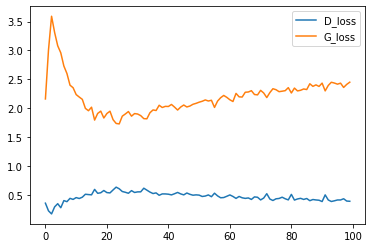

test_loss


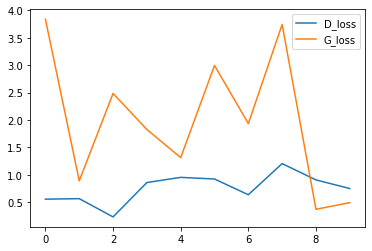

In [11]:
import pandas as pd
print('train_loss')
pd.DataFrame(gan._history[0]['train_loss_data']).plot()
plt.show()
print('test_loss')
pd.DataFrame(gan._history[0]['test_loss_data']).plot()
plt.show()

# Generated Images

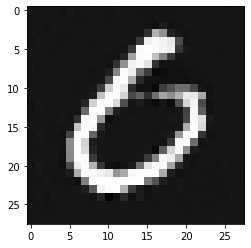

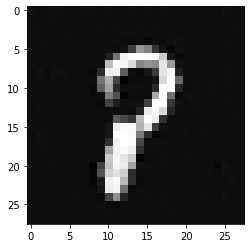

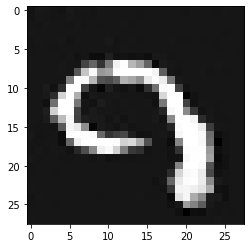

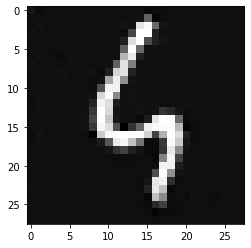

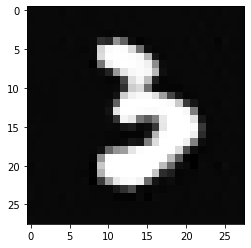

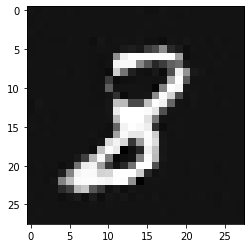

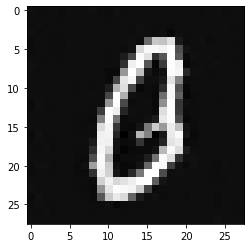

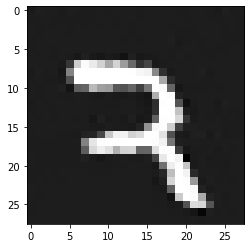

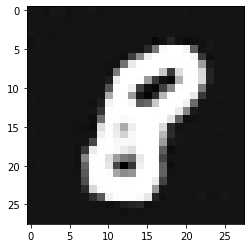

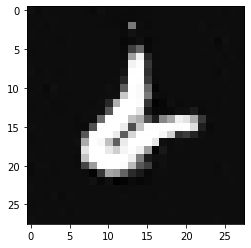

tensor([[0.2594],
        [0.5011],
        [0.3176],
        [0.6418],
        [0.5774],
        [0.2183],
        [0.6255],
        [0.3584],
        [0.1656],
        [0.3209]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [12]:
gan.eval()
gan.g.eval()
gan.d.eval()
generated = gan.sample(10)
# generated = gan.g(torch.randn((3,100), device='cuda'))
btorch.vision.utils.pplot(generated)
print(gan.d(generated))

# Discriminator on Real Image

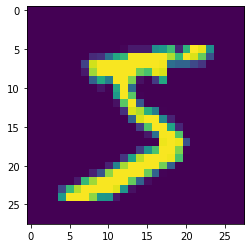

tensor([0.6793], device='cuda:0', grad_fn=<SelectBackward0>)


In [13]:
gan.eval()
gan.g.eval()
gan.d.eval()
for i in trainset:
  btorch.vision.utils.pplot(i[0][0])
  print(gan.d(i[0].unsqueeze(0).cuda())[0])
  break

# Evolution of Generator

epoch 0


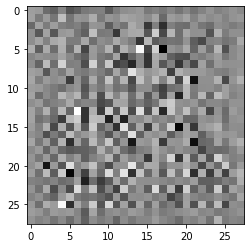

epoch 1


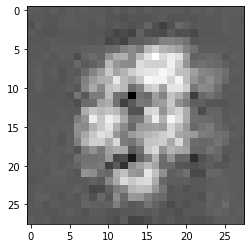

epoch 2


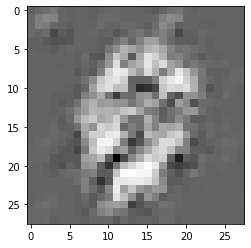

epoch 3


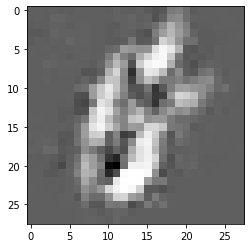

epoch 4


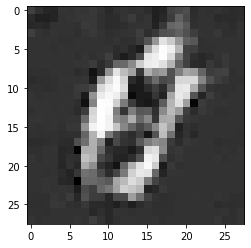

epoch 5


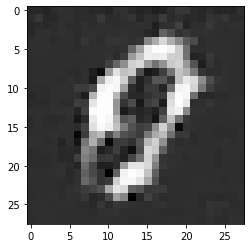

epoch 6


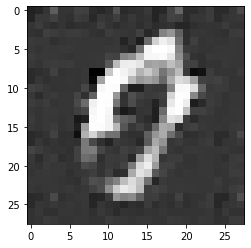

epoch 7


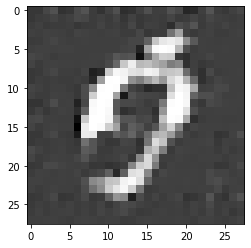

epoch 8


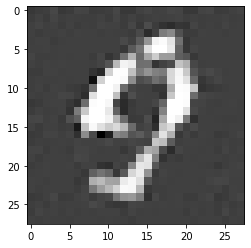

epoch 9


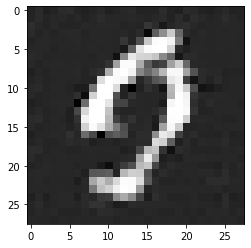

epoch 10


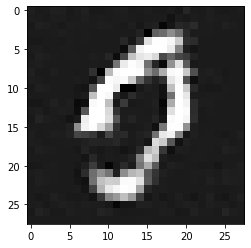

epoch 11


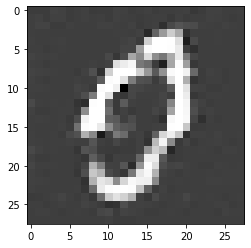

epoch 12


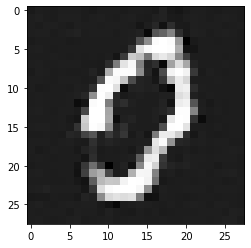

epoch 13


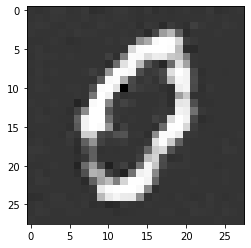

epoch 14


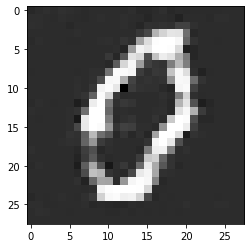

epoch 15


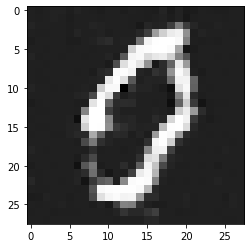

epoch 16


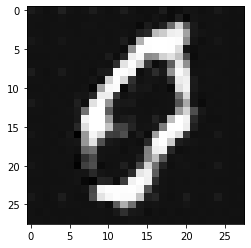

epoch 17


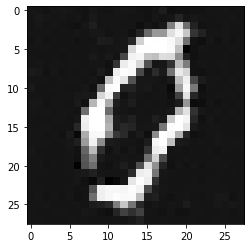

epoch 18


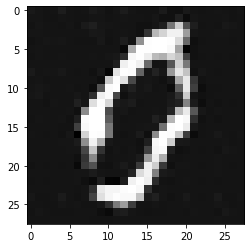

epoch 19


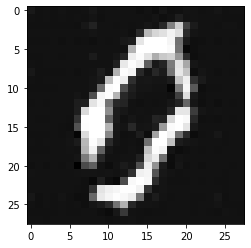

epoch 20


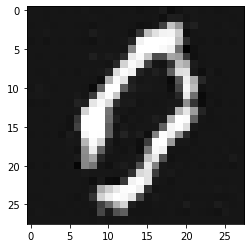

epoch 21


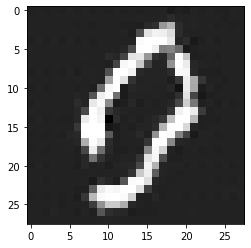

epoch 22


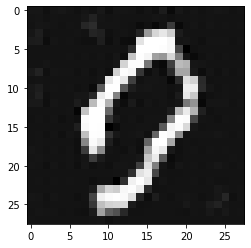

epoch 23


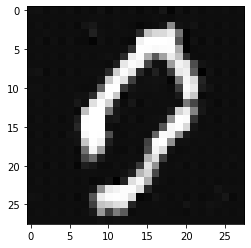

epoch 24


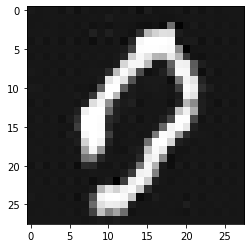

epoch 25


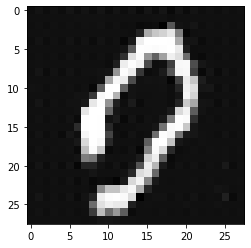

epoch 26


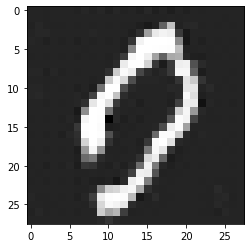

epoch 27


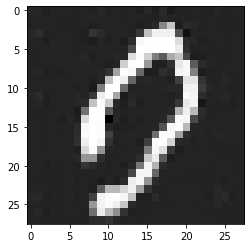

epoch 28


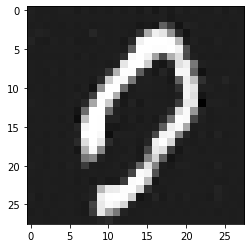

epoch 29


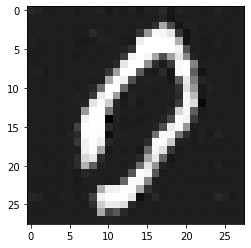

epoch 30


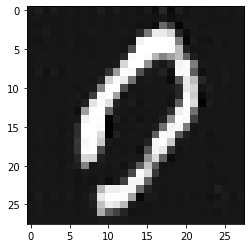

epoch 31


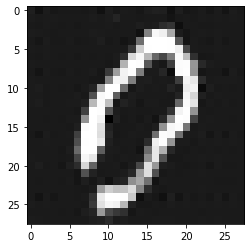

epoch 32


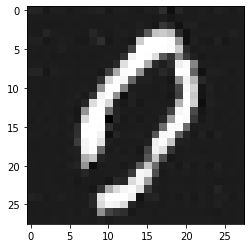

epoch 33


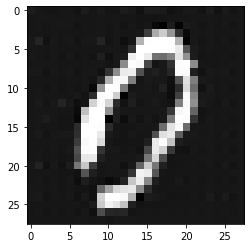

epoch 34


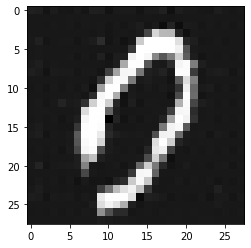

epoch 35


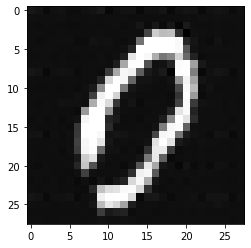

epoch 36


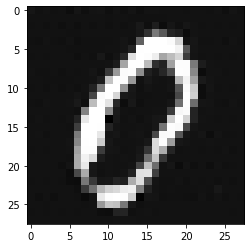

epoch 37


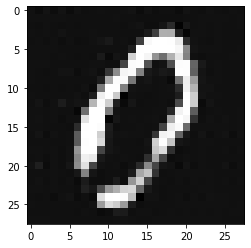

epoch 38


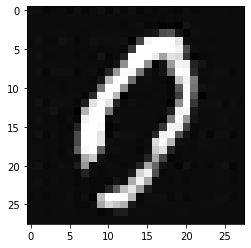

epoch 39


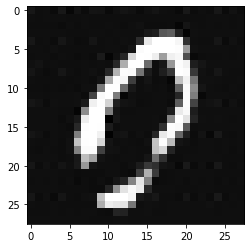

epoch 40


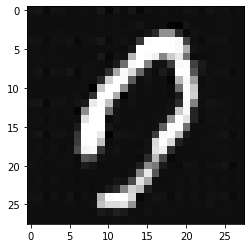

epoch 41


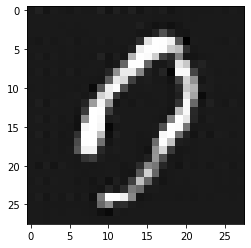

epoch 42


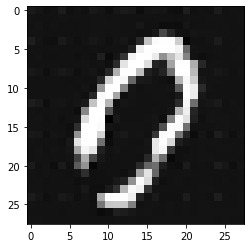

epoch 43


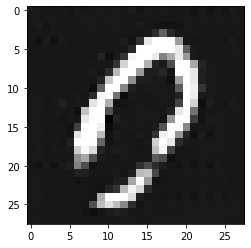

epoch 44


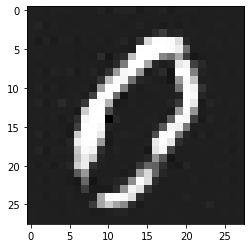

epoch 45


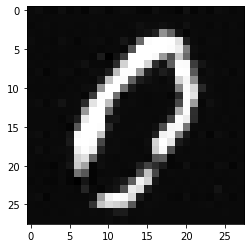

epoch 46


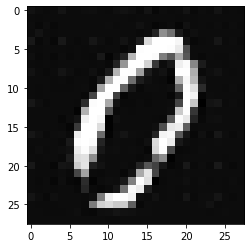

epoch 47


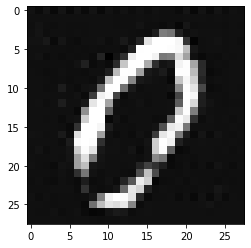

epoch 48


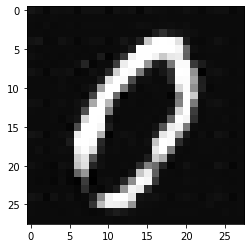

epoch 49


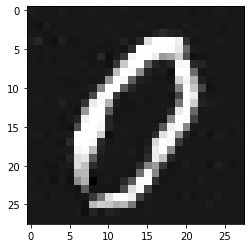

epoch 50


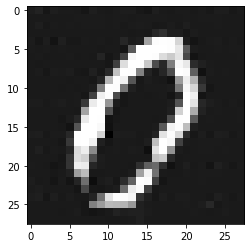

epoch 51


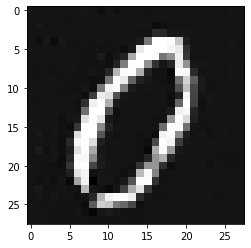

epoch 52


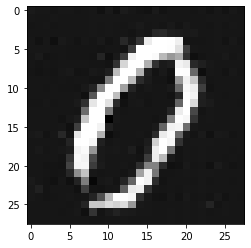

epoch 53


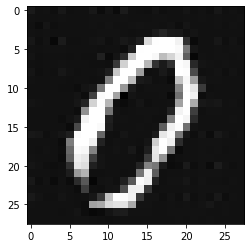

epoch 54


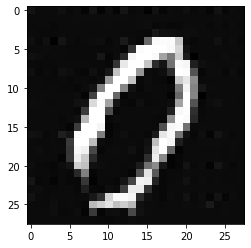

epoch 55


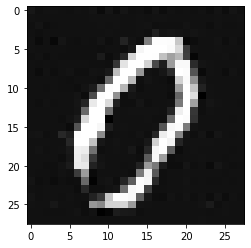

epoch 56


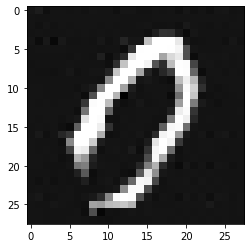

epoch 57


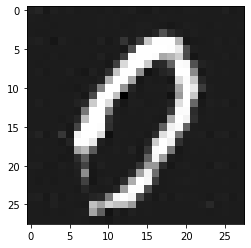

epoch 58


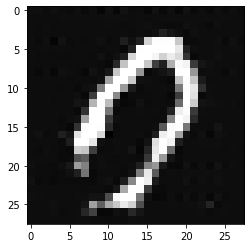

epoch 59


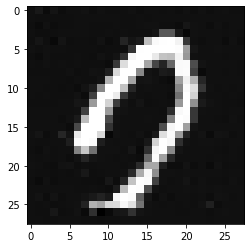

epoch 60


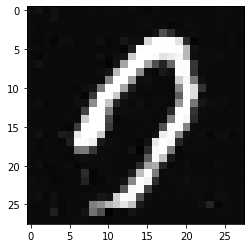

epoch 61


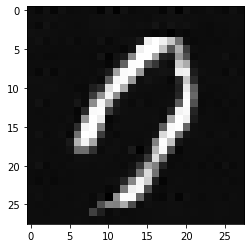

epoch 62


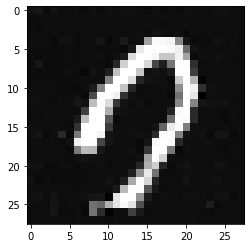

epoch 63


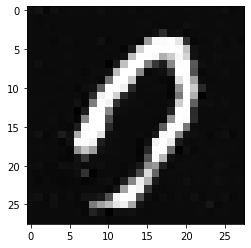

epoch 64


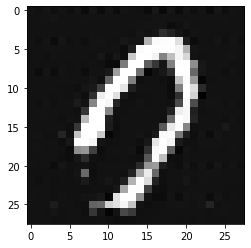

epoch 65


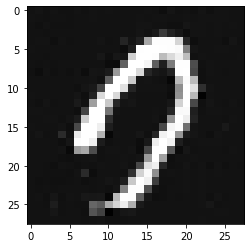

epoch 66


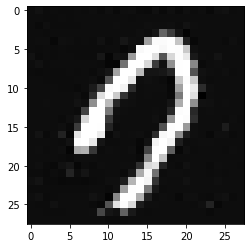

epoch 67


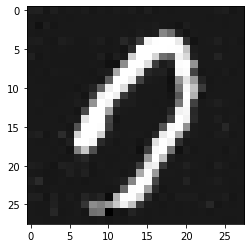

epoch 68


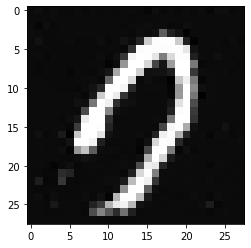

epoch 69


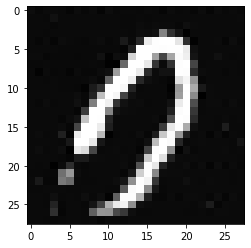

epoch 70


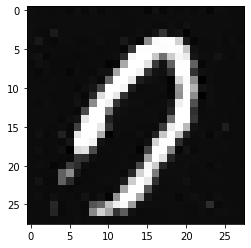

epoch 71


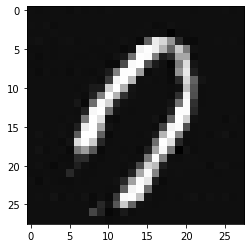

epoch 72


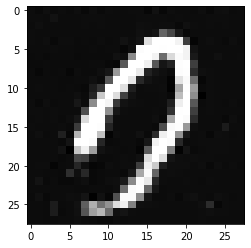

epoch 73


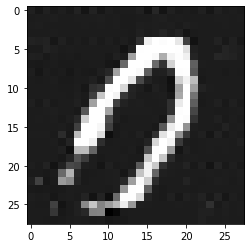

epoch 74


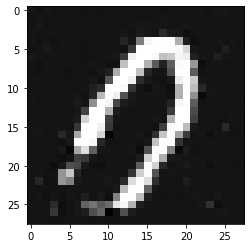

epoch 75


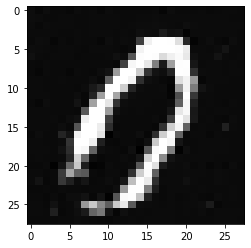

epoch 76


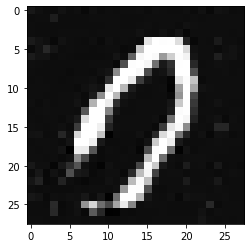

epoch 77


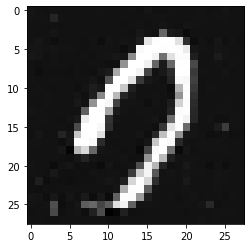

epoch 78


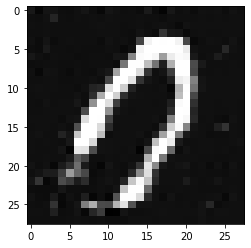

epoch 79


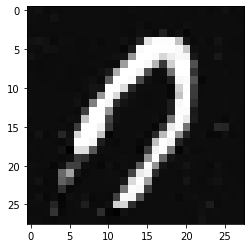

epoch 80


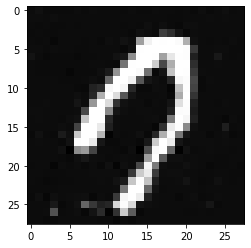

epoch 81


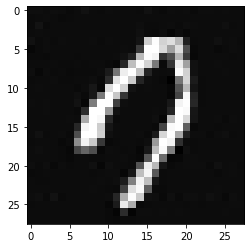

epoch 82


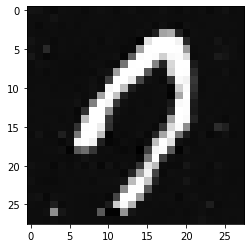

epoch 83


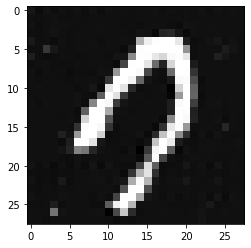

epoch 84


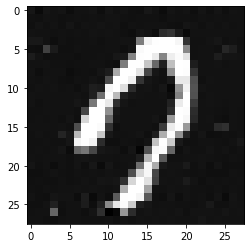

epoch 85


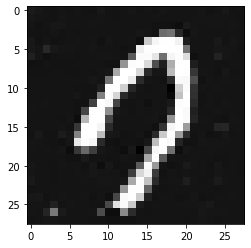

epoch 86


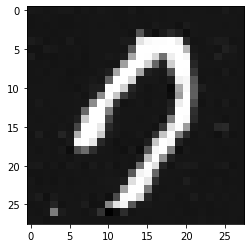

epoch 87


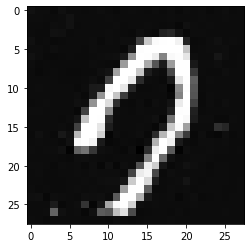

epoch 88


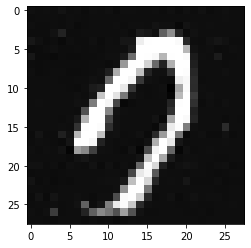

epoch 89


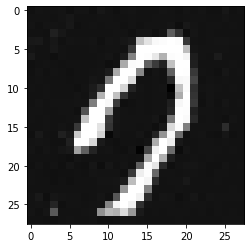

epoch 90


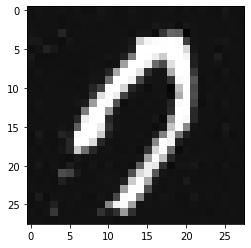

epoch 91


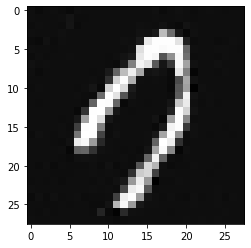

epoch 92


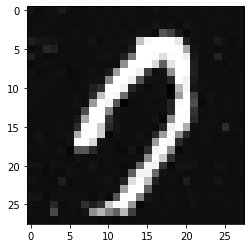

epoch 93


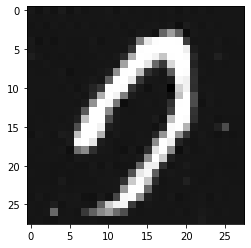

epoch 94


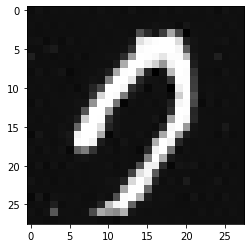

epoch 95


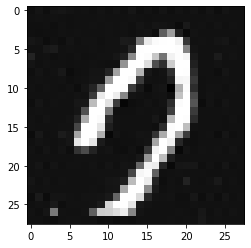

epoch 96


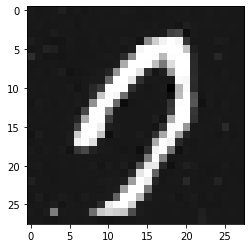

epoch 97


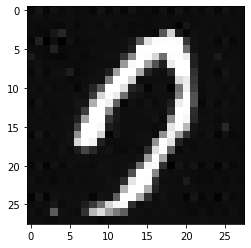

epoch 98


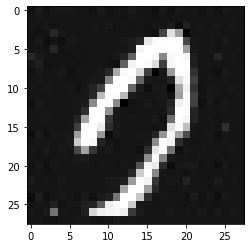

epoch 99


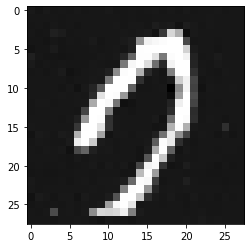

In [14]:
for i in range(0,len(gan._config['evol']), 1):
  print(f"epoch {i}")
  btorch.vision.utils.pplot(gan._config['evol'][i])